# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian

Note that we have two folders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

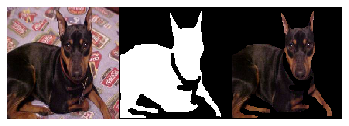

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [9]:
model = unet()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training









i= 1 loss= 0.558747341507646 val_loss= 0.4347002072767778 mean_iou= 0.14178981633001753 val_mean_iou= 0.49508079344576056


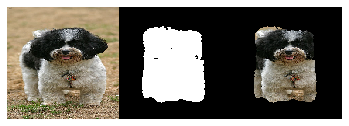

i= 2 loss= 0.44312322643249547 val_loss= 0.4299759864807129 mean_iou= 0.44175327269656245 val_mean_iou= 0.3762212666598233


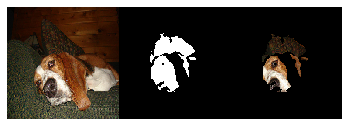

i= 3 loss= 0.42564511884293055 val_loss= 0.4949907254089009 mean_iou= 0.4698299299500304 val_mean_iou= 0.30414448272098193


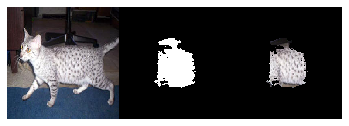

i= 4 loss= 0.3974699727748627 val_loss= 0.37728592211549933 mean_iou= 0.5102431575457255 val_mean_iou= 0.5006333860484037


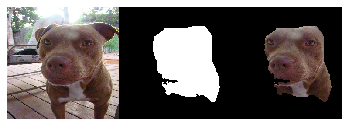

i= 5 loss= 0.35583002994593965 val_loss= 0.3270965652032332 mean_iou= 0.5721797540988007 val_mean_iou= 0.5692723826928572


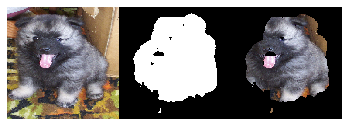

i= 6 loss= 0.316545752970051 val_loss= 0.29976740750399505 mean_iou= 0.6259229513880324 val_mean_iou= 0.6301619085398588


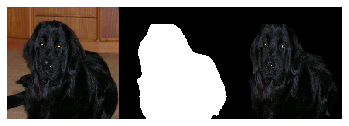

i= 7 loss= 0.2843550220472083 val_loss= 0.25242930379780854 mean_iou= 0.6656683469063616 val_mean_iou= 0.686061062596061


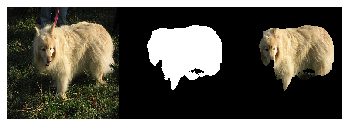

i= 8 loss= 0.2635194841585203 val_loss= 0.2921699583530426 mean_iou= 0.6880028151213851 val_mean_iou= 0.7151323123411699


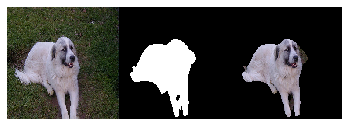

i= 9 loss= 0.2423423482402819 val_loss= 0.23382174155928873 mean_iou= 0.7152308901967523 val_mean_iou= 0.7246662811799482


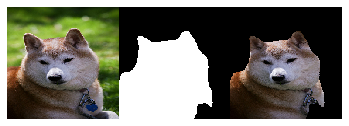

i= 10 loss= 0.22873163726776158 val_loss= 0.2071765268390829 mean_iou= 0.7291227753303912 val_mean_iou= 0.7445429942824624


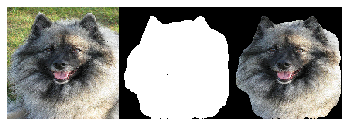

i= 11 loss= 0.20793815719210393 val_loss= 0.21128833293914795 mean_iou= 0.7566880782445272 val_mean_iou= 0.7449890050021085


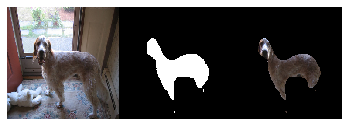

i= 12 loss= 0.1954924903435794 val_loss= 0.2011336548761888 mean_iou= 0.7642393310864767 val_mean_iou= 0.7857965718616139


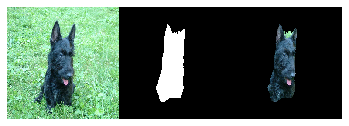

i= 13 loss= 0.18508157970970623 val_loss= 0.23161907494068146 mean_iou= 0.7806335004497337 val_mean_iou= 0.7610084197737954


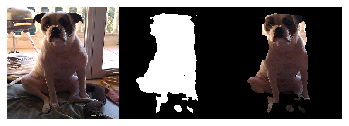

i= 14 loss= 0.17808307067716503 val_loss= 0.20267234200781042 mean_iou= 0.7880554860585356 val_mean_iou= 0.7525115554982965


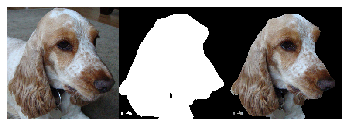

i= 15 loss= 0.16378664558744865 val_loss= 0.25432484122839843 mean_iou= 0.8045880089611768 val_mean_iou= 0.6892695372754877


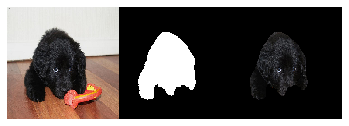

i= 16 loss= 0.1587187700551939 val_loss= 0.21691896969621832 mean_iou= 0.8061650142277756 val_mean_iou= 0.7561303973197937


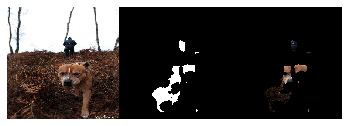

i= 17 loss= 0.15153651841018842 val_loss= 0.19794270260767502 mean_iou= 0.8187103535486683 val_mean_iou= 0.7830100926485929


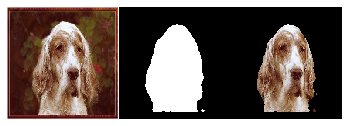

i= 18 loss= 0.137529132402923 val_loss= 0.1843250122937289 mean_iou= 0.829894999663035 val_mean_iou= 0.7861071283167059


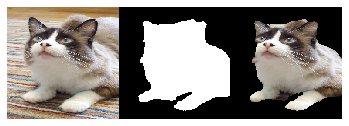

i= 19 loss= 0.1341067935301833 val_loss= 0.22618848220868545 mean_iou= 0.8337354670920872 val_mean_iou= 0.7697957862507213


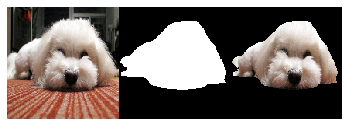

i= 20 loss= 0.12950567183293163 val_loss= 0.20226296376098285 mean_iou= 0.8407686243862866 val_mean_iou= 0.7883199182423678


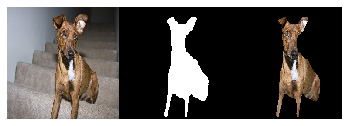

i= 21 loss= 0.12226286571319789 val_loss= 0.1848663931543177 mean_iou= 0.8458685227180724 val_mean_iou= 0.7880780534310774


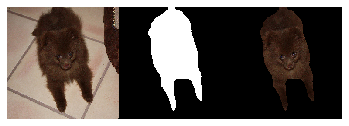

i= 22 loss= 0.1172789988112232 val_loss= 0.27401637218215247 mean_iou= 0.8525405351974104 val_mean_iou= 0.75327453288165


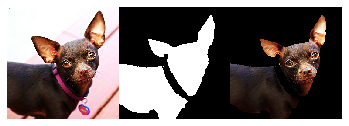

i= 23 loss= 0.11748960246778514 val_loss= 0.20334016599438406 mean_iou= 0.854346263898562 val_mean_iou= 0.7892371524464


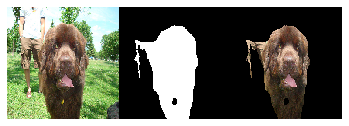

i= 24 loss= 0.11018443560083163 val_loss= 0.19126394391059875 mean_iou= 0.8602426691686726 val_mean_iou= 0.7931389808654785


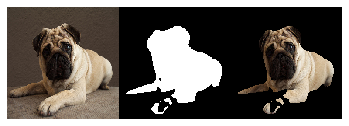

i= 25 loss= 0.10427429550858937 val_loss= 0.204590267078443 mean_iou= 0.8678016335996863 val_mean_iou= 0.7931528199802745


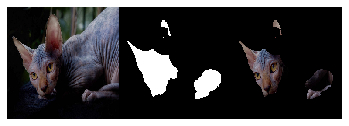

i= 26 loss= 0.1002206201558788 val_loss= 0.19847414168444547 mean_iou= 0.8723554687412907 val_mean_iou= 0.8065365932204507


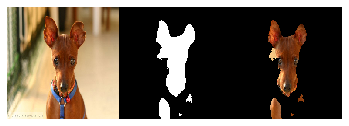

i= 27 loss= 0.09775259151850661 val_loss= 0.1717795120044188 mean_iou= 0.8748870911119191 val_mean_iou= 0.8191994428634644


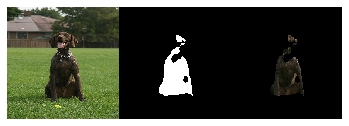

i= 28 loss= 0.09466200042941254 val_loss= 0.17804716391996903 mean_iou= 0.8788109530596973 val_mean_iou= 0.8198967250910673


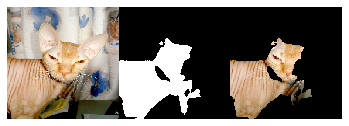

i= 29 loss= 0.09203058430185057 val_loss= 0.1830974275415594 mean_iou= 0.8830208993393537 val_mean_iou= 0.813274784521623


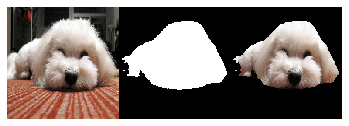

i= 30 loss= 0.09083944633943306 val_loss= 0.22134842384945264 mean_iou= 0.8832151862584292 val_mean_iou= 0.7843907150355253


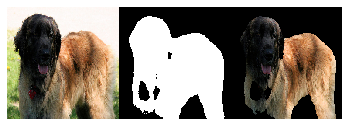

In [12]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [13]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-11 12:52:38--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.227.220.20, 13.227.220.11, 13.227.220.14, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.227.220.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.005s  

2020-03-11 12:52:38 (12.0 MB/s) - ‘test.jpg’ saved [63219/63219]



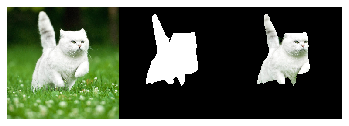

In [14]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

